### 多层感知机(Multilayer Perceptron，MLP)
1. 仿射变换(Affine Transformation): 指在几何中，一个向量空间进行一次线性变换并接上一个平移，变换为另一个向量空间
2. 激活函数
    - ReLU函数: 
    - Sigmoid
    - Tanh

### Sigmoid 函数求导
已知: $$ s(x) = \frac{1}{1+e^{-x}} $$
令 $$ s(y) = \frac{1}{1+y}, y(z) = e^z , z(x) = -x $$
那么: $$ 
\frac{\vartheta s}{\vartheta x} = \frac{\vartheta s}{\vartheta y} \frac{\vartheta y}{\vartheta z} \frac{\vartheta z}{\vartheta x} = \frac{(1+y)^{'} - 0}{(1+y)^2} e^{z} (-1) = - \frac{1}{(1+y)^2} e^{z} $$
又因为 $$ y(s) = s^{-1} - 1 $$,
所以, $$ \frac{\vartheta s}{\vartheta x} = - \frac{1}{(1+y)^2} y = - \frac{1}{(1+ s^{-1} -1)^2} (s^{-1} - 1) $$
上下同时乘上s的平方, 可得:
$$ \frac{\vartheta s}{\vartheta x} = s(1-s) $$

### Tanh 函数求导
已知 $$ tanh(x) = \frac{1 - e^{-2x}}{1 + e^(-2x)} $$
目标: $$ tanh^{'}(x) = 1 - tanh^2(x) $$
求导: 令 $$ t(y) = \frac{1-y}{1+y}, y(z) = e^z, z(x) = -2x $$
则 $$ 
\frac{\vartheta t}{\vartheta x} = \frac{\vartheta t}{\vartheta y} \frac{\vartheta y}{\vartheta z} \frac{\vartheta z}{\vartheta x} = -2e^z \frac{(1-y){^{'} - (1+y)^{'}}}{(1+y)^2} = -2e^z \frac{-2}{(1+y)^2}
$$
因为: $$ y(z) = e^z , y(t) = \frac{1-t}{1+t} $$
所以: $$ \frac{\vartheta t}{\vartheta x} = \frac{-4y}{(1+y)^2} $$ 
将y转为t, 得: $$ \frac{\vartheta t}{\vartheta x} = 1 - t^2 = 1 - tanh^{2}x $$

In [1]:
from mxnet import autograd, nd
from IPython import display
from matplotlib import pyplot as plt

In [2]:
# 可视化 激活函数

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def xyplot(x_vals, y_vals, name):
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    plt.xlabel('x')
    plt.ylabel(name + '(x)')

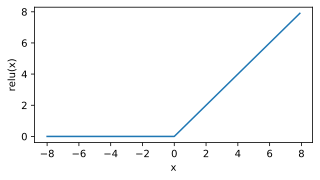

In [3]:
# ReLU
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()

with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

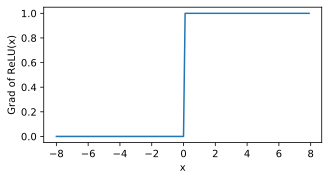

In [4]:
# 对 ReLU 求导
y.backward()
xyplot(x, x.grad, 'Grad of ReLU')  # 单位阶跃函数

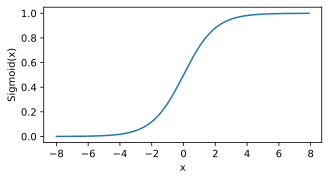

In [5]:
# Sigmoid
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'Sigmoid')

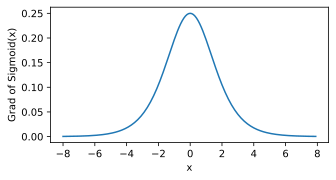

In [6]:
y.backward()
xyplot(x, x.grad, 'Grad of Sigmoid')

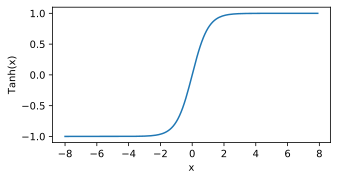

In [7]:
# tanh
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'Tanh')

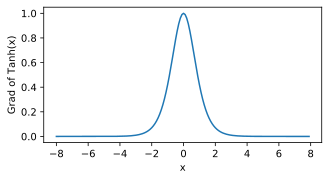

In [8]:
y.backward()
xyplot(x, x.grad, 'Grad of Tanh')

In [9]:
%matplotlib inline
import sys, time
import numpy as np
from mxnet import nd, gluon
from mxnet.gluon import loss as gloss

In [10]:
# 预处理数据

def get_dataloader_workers(num_workers=4):
    # 0 means no additional process is used to speed up the reading of data.
    if sys.platform.startswith('win'):
        return 0
    else:
        return num_workers
    
    
def load_data_fashion_mnist(batch_size, resize=None):
    dataset = gluon.data.vision
    trans = [dataset.transforms.Resize(resize)] if resize else []
    trans.append(dataset.transforms.ToTensor())
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

In [11]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [12]:
# 定义模型参数, 并初始化
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_hiddens))
b1 = nd.zeros(num_hiddens)
W2 = nd.random.normal(scale=0.01, shape=(num_hiddens, num_outputs))
b2 = nd.zeros(num_outputs)
params = [W1, b1, W2, b2]

for param in params:
    param.attach_grad()

In [13]:
# 定义激活函数
def relu(X):
    return nd.maximum(X, 0)

In [14]:
# 定义优化模型
def net(X):
    X = X.reshape((-1, num_inputs)) # 列向量
    H = relu(nd.dot(X, W1) + b1)
    return nd.dot(H, W2) + b2

In [15]:
# 定义损失函数
loss = gloss.SoftmaxCrossEntropyLoss()

In [16]:
# 计算预测准确率
def accuracy(y_hat, y):
#     return (nd.argmax(y_hat) == y).sum()/y.shape[0]
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [17]:
# 评估模型
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [18]:
# 训练模型
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

        
def plot_train_test_rate(train_hist, test_hist):
    x_vals = range(len(train_hist))
    set_figsize(figsize=(5, 2.5))
    plt.plot(x_vals, train_hist)
    plt.plot(x_vals, test_hist)
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    
        
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    train_hist = list()
    test_hist = list()
    for epoch in range(num_epochs):
        epoch_time = time.time()
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        train_acc = train_acc_sum / n
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, costs %.4f, loss %.4f, train acc %.2f%%, test acc %.2f%%'
              % (epoch + 1, time.time()-epoch_time, train_l_sum / n, train_acc * 100, test_acc * 100))
        train_hist.append(train_acc)
        test_hist.append(test_acc)
    return train_hist, test_hist

In [19]:
num_epochs, lr = 50, 0.5
train_hist, test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
          params, lr)  # 准确率好高

epoch 1, costs 3.7972, loss 0.7945, train acc 70.22%, test acc 82.96%
epoch 2, costs 3.2478, loss 0.4879, train acc 81.71%, test acc 84.45%
epoch 3, costs 3.4673, loss 0.4255, train acc 84.29%, test acc 85.62%
epoch 4, costs 4.0488, loss 0.3932, train acc 85.48%, test acc 85.75%
epoch 5, costs 2.8337, loss 0.3758, train acc 86.15%, test acc 87.21%
epoch 6, costs 3.3921, loss 0.3538, train acc 86.82%, test acc 87.78%
epoch 7, costs 3.1792, loss 0.3365, train acc 87.55%, test acc 87.70%
epoch 8, costs 2.8503, loss 0.3216, train acc 88.09%, test acc 87.84%
epoch 9, costs 3.1023, loss 0.3129, train acc 88.30%, test acc 87.99%
epoch 10, costs 3.2735, loss 0.3033, train acc 88.69%, test acc 88.21%
epoch 11, costs 3.3694, loss 0.2973, train acc 88.78%, test acc 88.78%
epoch 12, costs 3.2119, loss 0.2853, train acc 89.45%, test acc 88.37%
epoch 13, costs 3.0442, loss 0.2812, train acc 89.51%, test acc 88.44%
epoch 14, costs 4.0149, loss 0.2742, train acc 89.92%, test acc 88.62%
epoch 15, costs

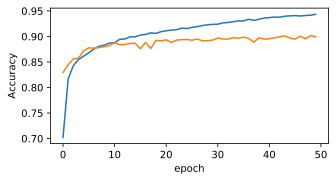

In [20]:
plot_train_test_rate(train_hist, test_hist)

In [21]:
# 中间层增减对 结果和过程的影响

### MXNet版本的多层感知机

In [22]:
from mxnet import gluon, init
from mxnet.gluon import loss as gloss, nn

In [23]:
# 定义模型
net = nn.Sequential()
net.add(nn.Dense(num_hiddens, activation='relu'), nn.Dense(num_outputs))

In [24]:
# 初始化 参数
net.initialize(init.Normal(sigma=0.01))

In [25]:
# 选择 损失函数
loss = gloss.SoftmaxCrossEntropyLoss()

In [26]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
train_hist, test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)

epoch 1, costs 3.1610, loss 0.8103, train acc 69.68%, test acc 82.16%
epoch 2, costs 3.1692, loss 0.4936, train acc 81.81%, test acc 84.77%
epoch 3, costs 3.1969, loss 0.4285, train acc 84.16%, test acc 86.53%
epoch 4, costs 3.3337, loss 0.3939, train acc 85.39%, test acc 86.87%
epoch 5, costs 3.0636, loss 0.3732, train acc 86.30%, test acc 86.99%
epoch 6, costs 3.6168, loss 0.3543, train acc 86.87%, test acc 87.34%
epoch 7, costs 2.8541, loss 0.3425, train acc 87.36%, test acc 87.74%
epoch 8, costs 2.7085, loss 0.3292, train acc 87.85%, test acc 87.51%
epoch 9, costs 2.9863, loss 0.3189, train acc 88.31%, test acc 88.08%
epoch 10, costs 3.3695, loss 0.3046, train acc 88.77%, test acc 88.10%
epoch 11, costs 2.9537, loss 0.2993, train acc 88.93%, test acc 88.40%
epoch 12, costs 2.9459, loss 0.2920, train acc 89.20%, test acc 88.36%
epoch 13, costs 3.0113, loss 0.2823, train acc 89.48%, test acc 88.67%
epoch 14, costs 3.4145, loss 0.2768, train acc 89.64%, test acc 88.77%
epoch 15, costs

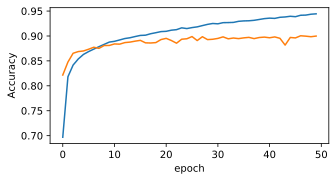

In [27]:
plot_train_test_rate(train_hist, test_hist)

### 练习
1. 隐藏层的个数/层数增减对结果有什么影响?
2. 使用其他激活函数会对 结果有什么影响? 可以对比一下

epoch 1, costs 2.3853, loss 2.0969, train acc 17.85%, test acc 10.91%
epoch 2, costs 2.1341, loss 2.1575, train acc 15.78%, test acc 10.04%
epoch 3, costs 2.1105, loss 2.3038, train acc 9.94%, test acc 10.06%
epoch 4, costs 2.4770, loss 2.2344, train acc 12.49%, test acc 23.61%
epoch 5, costs 3.0949, loss 2.1605, train acc 14.98%, test acc 10.03%
epoch 6, costs 3.1097, loss 2.3032, train acc 9.90%, test acc 10.03%
epoch 7, costs 2.3047, loss 2.3030, train acc 10.05%, test acc 10.00%
epoch 8, costs 2.4350, loss 2.3020, train acc 10.14%, test acc 10.96%
epoch 9, costs 2.5304, loss 2.1970, train acc 14.93%, test acc 20.09%
epoch 10, costs 2.3460, loss 2.0310, train acc 18.39%, test acc 10.00%
epoch 11, costs 2.2637, loss 2.3089, train acc 10.12%, test acc 19.70%
epoch 12, costs 2.6541, loss 2.1160, train acc 16.23%, test acc 10.29%
epoch 13, costs 2.4567, loss 2.0446, train acc 17.82%, test acc 21.27%
epoch 14, costs 2.3760, loss 2.0325, train acc 18.45%, test acc 12.76%
epoch 15, costs 2

epoch 16, costs 2.6434, loss 0.4596, train acc 83.29%, test acc 84.99%
epoch 17, costs 2.6239, loss 0.4599, train acc 83.23%, test acc 82.22%
epoch 18, costs 2.6842, loss 0.4569, train acc 83.43%, test acc 84.86%
epoch 19, costs 2.5154, loss 0.4497, train acc 83.58%, test acc 85.16%
epoch 20, costs 2.5766, loss 0.4420, train acc 83.87%, test acc 83.82%
epoch 21, costs 2.7079, loss 0.4380, train acc 84.09%, test acc 84.25%
epoch 22, costs 2.6925, loss 0.4394, train acc 83.99%, test acc 84.69%
epoch 23, costs 2.2188, loss 0.4393, train acc 84.01%, test acc 84.76%
epoch 24, costs 2.2134, loss 0.4343, train acc 84.19%, test acc 83.67%
epoch 25, costs 2.2298, loss 0.4356, train acc 84.02%, test acc 84.97%
epoch 26, costs 2.4085, loss 0.4293, train acc 84.25%, test acc 84.05%
epoch 27, costs 2.2574, loss 0.4205, train acc 84.70%, test acc 85.34%
epoch 28, costs 2.2162, loss 0.4203, train acc 84.58%, test acc 84.55%
epoch 29, costs 2.5452, loss 0.4170, train acc 84.76%, test acc 84.91%
epoch 

epoch 30, costs 3.0659, loss 0.2312, train acc 91.36%, test acc 88.91%
epoch 31, costs 3.2747, loss 0.2275, train acc 91.55%, test acc 88.92%
epoch 32, costs 3.6644, loss 0.2272, train acc 91.43%, test acc 88.50%
epoch 33, costs 2.9433, loss 0.2223, train acc 91.59%, test acc 88.83%
epoch 34, costs 2.9438, loss 0.2206, train acc 91.78%, test acc 89.38%
epoch 35, costs 2.5616, loss 0.2175, train acc 91.77%, test acc 88.97%
epoch 36, costs 2.6553, loss 0.2155, train acc 91.92%, test acc 89.37%
epoch 37, costs 2.8863, loss 0.2148, train acc 91.92%, test acc 89.09%
epoch 38, costs 2.8866, loss 0.2096, train acc 92.22%, test acc 88.59%
epoch 39, costs 3.0757, loss 0.2104, train acc 92.14%, test acc 88.50%
epoch 40, costs 2.7528, loss 0.2084, train acc 92.18%, test acc 88.90%
epoch 41, costs 2.4795, loss 0.2067, train acc 92.25%, test acc 88.64%
epoch 42, costs 2.8013, loss 0.2019, train acc 92.33%, test acc 89.61%
epoch 43, costs 2.5259, loss 0.1994, train acc 92.47%, test acc 88.71%
epoch 

epoch 44, costs 5.4611, loss 0.1456, train acc 94.68%, test acc 90.06%
epoch 45, costs 7.0821, loss 0.1447, train acc 94.66%, test acc 90.33%
epoch 46, costs 5.8665, loss 0.1415, train acc 94.87%, test acc 90.17%
epoch 47, costs 5.7161, loss 0.1399, train acc 94.74%, test acc 89.95%
epoch 48, costs 5.8961, loss 0.1357, train acc 94.94%, test acc 90.34%
epoch 49, costs 5.4418, loss 0.1343, train acc 95.03%, test acc 90.28%
epoch 50, costs 5.9553, loss 0.1297, train acc 95.27%, test acc 89.72%
Num of Hidden Layers: 1000, Average Time Consumming of Each Epoch: 6.5864
epoch 1, costs 13.6901, loss 0.7171, train acc 73.51%, test acc 82.24%
epoch 2, costs 13.6508, loss 0.4673, train acc 82.62%, test acc 85.97%
epoch 3, costs 16.6997, loss 0.4063, train acc 84.98%, test acc 86.78%
epoch 4, costs 23.1339, loss 0.3778, train acc 85.92%, test acc 87.16%
epoch 5, costs 13.9621, loss 0.3520, train acc 87.12%, test acc 87.83%
epoch 6, costs 15.0200, loss 0.3365, train acc 87.56%, test acc 88.46%
epo

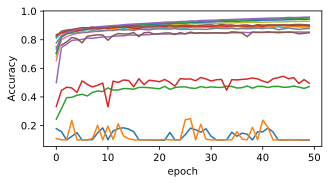

In [28]:
# 练习一: 中间层不同个数
range_of_hidden = [1, 3, 10, 30, 100, 300, 1000, 3000]
for num_of_hidden in range_of_hidden:
    # 定义 优化模型 和 激活函数
    epoch_time = time.time()
    net = nn.Sequential()
    net.add(nn.Dense(num_of_hidden, activation='relu'), nn.Dense(num_outputs))
    # 初始化参数
    net.initialize(init.Normal(sigma=0.01))
    # 定义损失函数
    loss = gloss.SoftmaxCrossEntropyLoss()
    # 开始训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    _train_hist, _test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)
    print("Num of Hidden Layers: {}, Average Time Consumming of Each Epoch: {:.4f}".format(num_of_hidden, (time.time() - epoch_time) / num_epochs))
    plot_train_test_rate(_train_hist, _test_hist)

在上面8个数中, 层数越多, 测试集的准确率越高

epoch 1, costs 3.6602, loss 0.8094, train acc 69.81%, test acc 81.91%
epoch 2, costs 3.6165, loss 0.4831, train acc 82.07%, test acc 85.24%
epoch 3, costs 3.6310, loss 0.4266, train acc 84.14%, test acc 85.28%
epoch 4, costs 3.5034, loss 0.3966, train acc 85.29%, test acc 86.53%
epoch 5, costs 3.5477, loss 0.3701, train acc 86.30%, test acc 87.43%
epoch 6, costs 3.4123, loss 0.3569, train acc 86.70%, test acc 87.44%
epoch 7, costs 3.4541, loss 0.3378, train acc 87.48%, test acc 88.17%
epoch 8, costs 3.4930, loss 0.3260, train acc 87.95%, test acc 88.03%
epoch 9, costs 3.4041, loss 0.3135, train acc 88.38%, test acc 87.71%
epoch 10, costs 3.6702, loss 0.3065, train acc 88.58%, test acc 86.34%
epoch 11, costs 3.2663, loss 0.2949, train acc 89.01%, test acc 88.48%
epoch 12, costs 4.4787, loss 0.2870, train acc 89.41%, test acc 88.24%
epoch 13, costs 4.0748, loss 0.2825, train acc 89.52%, test acc 88.47%
epoch 14, costs 3.7458, loss 0.2754, train acc 89.77%, test acc 88.00%
epoch 15, costs

epoch 15, costs 4.5867, loss 0.3064, train acc 88.72%, test acc 87.87%
epoch 16, costs 4.4524, loss 0.3000, train acc 88.87%, test acc 87.66%
epoch 17, costs 4.4801, loss 0.2940, train acc 89.04%, test acc 87.73%
epoch 18, costs 4.4785, loss 0.2837, train acc 89.43%, test acc 87.41%
epoch 19, costs 4.4273, loss 0.2755, train acc 89.60%, test acc 88.55%
epoch 20, costs 4.6694, loss 0.2702, train acc 89.95%, test acc 88.81%
epoch 21, costs 4.4224, loss 0.2669, train acc 89.94%, test acc 88.68%
epoch 22, costs 4.2628, loss 0.2592, train acc 90.25%, test acc 89.09%
epoch 23, costs 4.3525, loss 0.2572, train acc 90.33%, test acc 88.91%
epoch 24, costs 4.5910, loss 0.2526, train acc 90.48%, test acc 88.73%
epoch 25, costs 4.5800, loss 0.2487, train acc 90.62%, test acc 89.22%
epoch 26, costs 4.3811, loss 0.2437, train acc 90.95%, test acc 88.94%
epoch 27, costs 4.5107, loss 0.2375, train acc 91.09%, test acc 88.77%
epoch 28, costs 4.5271, loss 0.2320, train acc 91.27%, test acc 89.14%
epoch 

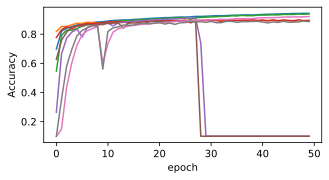

In [29]:
# 练习一: 中间层不同层数
num_hiddens = 256
range_of_layers = range(1, 5)
for num_layer in range_of_layers:
    # 定义模型
    epoch_time = time.time()
    layers = [nn.Dense(num_hiddens, activation='relu') for _ in range(num_layer)]
    layers.append(nn.Dense(num_outputs))
    net = nn.Sequential()
    net.add(*layers)
    net.initialize(init.Normal(sigma=0.01))
        # 定义损失函数
    loss = gloss.SoftmaxCrossEntropyLoss()
    # 开始训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    _train_hist, _test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)
    print("Hidden Layers: {}, Average Time Consumming of Each Epoch: {:.4f}".format(num_layer, (time.time() - epoch_time) / num_epochs))
    plot_train_test_rate(_train_hist, _test_hist)

诡异的3层隐藏层

epoch 1, costs 3.7541, loss nan, train acc 11.52%, test acc 10.00%
epoch 2, costs 3.9865, loss nan, train acc 10.00%, test acc 10.00%
epoch 3, costs 3.3188, loss nan, train acc 10.00%, test acc 10.00%
epoch 4, costs 3.9574, loss nan, train acc 10.00%, test acc 10.00%
epoch 5, costs 3.3306, loss nan, train acc 10.00%, test acc 10.00%
epoch 6, costs 3.3025, loss nan, train acc 10.00%, test acc 10.00%
epoch 7, costs 3.2037, loss nan, train acc 10.00%, test acc 10.00%
epoch 8, costs 3.8383, loss nan, train acc 10.00%, test acc 10.00%
epoch 9, costs 3.4455, loss nan, train acc 10.00%, test acc 10.00%
epoch 10, costs 3.5834, loss nan, train acc 10.00%, test acc 10.00%
epoch 11, costs 3.8378, loss nan, train acc 10.00%, test acc 10.00%
epoch 12, costs 3.3299, loss nan, train acc 10.00%, test acc 10.00%
epoch 13, costs 2.9725, loss nan, train acc 10.00%, test acc 10.00%
epoch 14, costs 3.1762, loss nan, train acc 10.00%, test acc 10.00%
epoch 15, costs 4.0154, loss nan, train acc 10.00%, test 

epoch 17, costs 3.1625, loss 0.3444, train acc 87.51%, test acc 87.41%
epoch 18, costs 3.1336, loss 0.3416, train acc 87.66%, test acc 86.61%
epoch 19, costs 3.1722, loss 0.3354, train acc 87.88%, test acc 87.51%
epoch 20, costs 3.1725, loss 0.3325, train acc 88.00%, test acc 86.09%
epoch 21, costs 3.1726, loss 0.3296, train acc 88.05%, test acc 87.39%
epoch 22, costs 3.1921, loss 0.3238, train acc 88.23%, test acc 87.12%
epoch 23, costs 3.1118, loss 0.3217, train acc 88.28%, test acc 88.02%
epoch 24, costs 3.1982, loss 0.3171, train acc 88.53%, test acc 87.50%
epoch 25, costs 3.2059, loss 0.3129, train acc 88.70%, test acc 87.71%
epoch 26, costs 3.1071, loss 0.3129, train acc 88.69%, test acc 87.87%
epoch 27, costs 3.1177, loss 0.3086, train acc 88.76%, test acc 87.79%
epoch 28, costs 3.0913, loss 0.3039, train acc 89.00%, test acc 87.98%
epoch 29, costs 3.1930, loss 0.3054, train acc 88.80%, test acc 87.53%
epoch 30, costs 3.1513, loss 0.2996, train acc 89.09%, test acc 88.39%
epoch 

epoch 31, costs 3.1937, loss 0.2639, train acc 90.07%, test acc 88.92%
epoch 32, costs 3.3285, loss 0.2598, train acc 90.25%, test acc 88.50%
epoch 33, costs 3.2399, loss 0.2520, train acc 90.62%, test acc 88.87%
epoch 34, costs 3.5082, loss 0.2523, train acc 90.67%, test acc 88.05%
epoch 35, costs 3.1932, loss 0.2502, train acc 90.67%, test acc 88.66%
epoch 36, costs 3.5200, loss 0.2489, train acc 90.74%, test acc 88.80%
epoch 37, costs 3.3630, loss 0.2473, train acc 90.79%, test acc 88.68%
epoch 38, costs 3.8714, loss 0.2421, train acc 90.95%, test acc 89.24%
epoch 39, costs 3.4575, loss 0.2427, train acc 90.96%, test acc 89.00%
epoch 40, costs 3.5535, loss 0.2350, train acc 91.24%, test acc 89.00%
epoch 41, costs 3.4773, loss 0.2366, train acc 91.17%, test acc 89.34%
epoch 42, costs 3.8851, loss 0.2355, train acc 91.22%, test acc 89.34%
epoch 43, costs 3.3050, loss 0.2336, train acc 91.27%, test acc 89.13%
epoch 44, costs 3.5197, loss 0.2274, train acc 91.48%, test acc 89.23%
epoch 

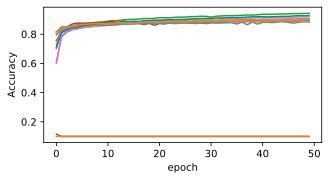

In [30]:
# 练习二: 不同激活函数
num_of_hidden = 256
activation_funcs = [None, 'relu', 'sigmoid', 'softrelu', 'softsign', 'tanh']
# ValueError: Deferred initialization failed because shape cannot be inferred. 
# Invalid Input: 'linear', valid values are: {'relu', 'sigmoid', 'softrelu', 'softsign', 'tanh'}, 
# in operator Activation(name="", act_type="linear")
for acfunc in activation_funcs:
    # 定义 优化模型 和 激活函数
    epoch_time = time.time()
    net = nn.Sequential()
    net.add(nn.Dense(num_of_hidden, activation=acfunc), nn.Dense(num_outputs))
    # 初始化参数
    net.initialize(init.Normal(sigma=0.01))
    # 定义损失函数
    loss = gloss.SoftmaxCrossEntropyLoss()
    # 开始训练
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    _train_hist, _test_hist = train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, trainer=trainer)
    print("Action Function: {}, Average Time Consumming of Each Epoch: {:.4f}".format(acfunc, (time.time() - epoch_time) / num_epochs))
    plot_train_test_rate(_train_hist, _test_hist)

### 拓展

In [31]:
# 1. 用 mxnet的方法可视化 激活函数
def visualize_activation(activation_fn):
    data = np.linspace(-10, 10, 501)
    x = nd.array(data)
    x.attach_grad()
    with autograd.record():
        y = activation_fn(x)
    y.backward()

    plt.figure()
    plt.plot(data, y.asnumpy())
    plt.plot(data, x.grad.asnumpy())
    activation = activation_fn.name[:-1]
    plt.legend(["{} activation".format(activation), "{} gradient".format(activation)])

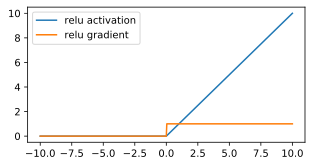

In [32]:
visualize_activation(nn.Activation('relu'))

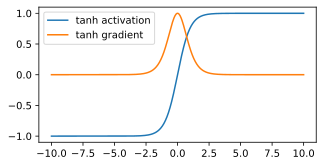

In [33]:
visualize_activation(nn.Activation('tanh'))

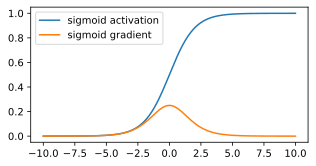

In [34]:
visualize_activation(nn.Activation('sigmoid'))

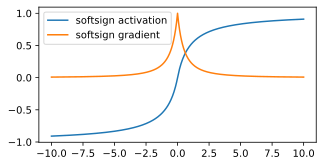

In [35]:
visualize_activation(nn.Activation('softsign'))

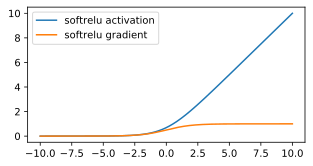

In [36]:
visualize_activation(nn.Activation('softrelu'))

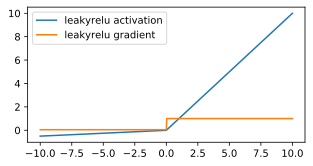

In [37]:
visualize_activation(nn.LeakyReLU(0.05))

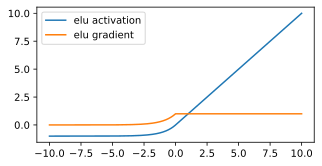

In [38]:
visualize_activation(nn.ELU())

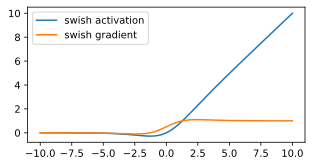

In [39]:
visualize_activation(nn.Swish())